# Customer churn prediction
This notebook uses a subset (128MB) of the full dataset available (12GB) for the convinence of manipulating data and build machine learning model locally. 

In [258]:
# import libraries
import datetime
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, isnan, count,countDistinct, udf, min, max, avg, desc, when, length
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator


In [84]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### 1. Load and overview of the data

In [85]:
# Load and read data as dataframe
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [86]:
num_rows = df.count()
num_cols = len(df.columns)
print('The data set contains {} rows and {} columns'.format(num_rows, num_cols))

The data set contains 286500 rows and 18 columns


In [87]:
# Show the fist row of the dataframe
df.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [88]:
# Show all the columns
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

### 2. Check missing values and clean data

In [89]:
def check_missing_values(df):
    """Check the number of missing values in each columns and calculate the missing rate
    
    Arguments:
        df {dataframe} -- spark dataframe
        
    Return: None    
    """
    print('Column name         null count   null rate\n')
    for c in df.columns:
        null_count = df.filter(df[c].isNull() | (df[c] == '') ).count() # Check whether each column has null value or empty string
        null_rate = null_count/df.count() 
        print('{:15} | {:10} | {:10}'.format(c, null_count, null_rate))

In [90]:
check_missing_values(df)

Column name         null count   null rate

artist          |      58392 | 0.20381151832460734
auth            |          0 |        0.0
firstName       |       8346 | 0.029130890052356022
gender          |       8346 | 0.029130890052356022
itemInSession   |          0 |        0.0
lastName        |       8346 | 0.029130890052356022
length          |      58392 | 0.20381151832460734
level           |          0 |        0.0
location        |       8346 | 0.029130890052356022
method          |          0 |        0.0
page            |          0 |        0.0
registration    |       8346 | 0.029130890052356022
sessionId       |          0 |        0.0
song            |      58392 | 0.20381151832460734
status          |          0 |        0.0
ts              |          0 |        0.0
userAgent       |       8346 | 0.029130890052356022
userId          |       8346 | 0.029130890052356022


It is shown above that columns such as 'firstName', 'gender', 'lastName', 'location', 'registration' and 'userAgent' all have 8346 missing values as 'userId', because these information are all 'userId' related. Since our purpose in this project is to analyze user behavior, it would be safe to drop those rows that have no user information. 


In [91]:
# Drop rows with missing user id
df_dropId = df.filter((df['userId'] != '' ) )

In [92]:
# Total rows left
df_dropId.count()

278154

Another case is that 3 song-related columns 'artist', 'length' and 'song' have the same number of missing values. Let's check their interaction with 'page' column to get some idea. 

In [93]:
df.groupby('page').agg({'artist':'count', 'length':'count', 'song':'count'}).show(25)

+--------------------+-----------+-------------+-------------+
|                page|count(song)|count(artist)|count(length)|
+--------------------+-----------+-------------+-------------+
|              Cancel|          0|            0|            0|
|    Submit Downgrade|          0|            0|            0|
|         Thumbs Down|          0|            0|            0|
|                Home|          0|            0|            0|
|           Downgrade|          0|            0|            0|
|         Roll Advert|          0|            0|            0|
|              Logout|          0|            0|            0|
|       Save Settings|          0|            0|            0|
|Cancellation Conf...|          0|            0|            0|
|               About|          0|            0|            0|
| Submit Registration|          0|            0|            0|
|            Settings|          0|            0|            0|
|               Login|          0|            0|       

The three song related columns exclusively relate with 'NextSong' in page column. We will explore it further in feature engineering section.

In [95]:
# df_drop = df_dropId.drop('artist', 'song')

Now, with missing user ids removed, let's see how many users in total are registered. 

In [96]:
# Check number of unique users
n_users = df.select('userId').dropDuplicates().count()
print('There are {} unique users in the dataset.'.format(n_users))

There are 226 unique users in the dataset.


Since user ids are unique values to idendify users, we don't need extra 'firstName' and 'lastName' columns. 

In [97]:
df_drop = df_drop.drop('firstName','lastName')

In [98]:
# Take a look at numerical columns
df_drop.select('itemInSession','registration','length','sessionId', 'status','ts').describe().show()


+-------+------------------+--------------------+------------------+------------------+------------------+--------------------+
|summary|     itemInSession|        registration|            length|         sessionId|            status|                  ts|
+-------+------------------+--------------------+------------------+------------------+------------------+--------------------+
|  count|            278154|              278154|            228108|            278154|            278154|              278154|
|   mean|114.89918174824018|1.535358834085619...|249.11718197783583|1042.5616241362698|209.10321620397335|1.540958915431790...|
| stddev|129.85172939948959|3.2913216163281236E9| 99.23517921058313| 726.5010362219864|  30.1513888513279|1.5068287123356583E9|
|    min|                 0|       1521380675000|           0.78322|                 1|               200|       1538352117000|
|    max|              1321|       1543247354000|        3024.66567|              2474|               40

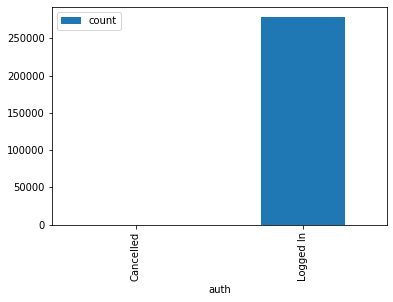

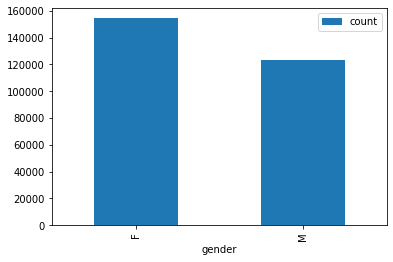

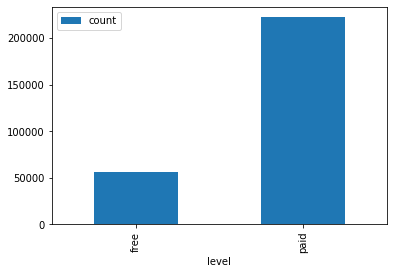

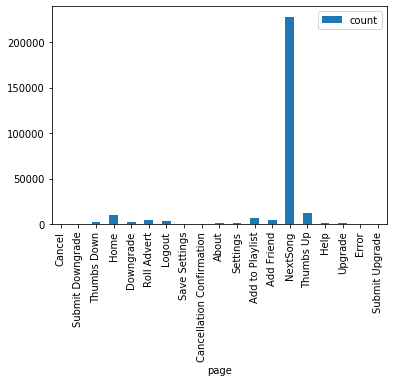

In [99]:
# Take a look at categorical columns
# count and plot occurences in each category in each column
cat_cols = ['auth', 'gender', 'level', 'page']
for c in cat_cols:
    grouped = df_drop.groupby(c).count().toPandas()
    grouped.plot.bar(x=c)

The 'status', 'method' and 'userAgent'column contains network related records, can also be dropped. 

In [100]:
df_drop = df_drop.drop('status','method','userAgent')

In [101]:
# Show cleaned dataset
# df_drop.show(5)

Above we cleaned the dataframe by dropping  rows with mising user id and columns that are not relevant. The next step is to define churn and perform exploratory data analysis.  

# Exploratory Data Analysis

### 1. Define Churn


About a detailed explanation about churn and churn rate, here is a [link](https://www.profitwell.com/blog/the-complete-saas-guide-to-calculating-churn-rate-and-keeping-it-simple) that I read and think is helpful. 

According to the link and my own understanding, in our dataset we can define churn using column "Cancelation Confirmation".

Let's take a look at the data to identify user churn and answer some questions.

### 2. Data Exploration

In [102]:
# Data overview
df_drop.show(5)

+---------+------+-------------+---------+-----+--------------------+--------+-------------+---------+-------------+------+
|     auth|gender|itemInSession|   length|level|            location|    page| registration|sessionId|           ts|userId|
+---------+------+-------------+---------+-----+--------------------+--------+-------------+---------+-------------+------+
|Logged In|     M|           50|277.89016| paid|     Bakersfield, CA|NextSong|1538173362000|       29|1538352117000|    30|
|Logged In|     M|           79|236.09424| free|Boston-Cambridge-...|NextSong|1538331630000|        8|1538352180000|     9|
|Logged In|     M|           51| 282.8273| paid|     Bakersfield, CA|NextSong|1538173362000|       29|1538352394000|    30|
|Logged In|     M|           80|262.71302| free|Boston-Cambridge-...|NextSong|1538331630000|        8|1538352416000|     9|
|Logged In|     M|           52|223.60771| paid|     Bakersfield, CA|NextSong|1538173362000|       29|1538352676000|    30|
+-------

In [103]:
# Format registration time and user behavior time
format_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_format = df_drop.withColumn('time',format_time(df_drop.ts))
df_format = df_format.withColumn('registrationTime', format_time(df_format.registration))
df_format = df_format.drop('ts','registration')
df_format.show(5)

+---------+------+-------------+---------+-----+--------------------+--------+---------+------+-------------------+-------------------+
|     auth|gender|itemInSession|   length|level|            location|    page|sessionId|userId|               time|   registrationTime|
+---------+------+-------------+---------+-----+--------------------+--------+---------+------+-------------------+-------------------+
|Logged In|     M|           50|277.89016| paid|     Bakersfield, CA|NextSong|       29|    30|2018-09-30 19:01:57|2018-09-28 17:22:42|
|Logged In|     M|           79|236.09424| free|Boston-Cambridge-...|NextSong|        8|     9|2018-09-30 19:03:00|2018-09-30 13:20:30|
|Logged In|     M|           51| 282.8273| paid|     Bakersfield, CA|NextSong|       29|    30|2018-09-30 19:06:34|2018-09-28 17:22:42|
|Logged In|     M|           80|262.71302| free|Boston-Cambridge-...|NextSong|        8|     9|2018-09-30 19:06:56|2018-09-30 13:20:30|
|Logged In|     M|           52|223.60771| paid|

#### Question 1: How many users canceled their accounts? What's the proportion to all users?

In [104]:
cancel_user = df_format.filter(df_format['page'] == 'Cancellation Confirmation').select('userId').dropDuplicates().count()
cancel_rate = cancel_user/ n_users * 100
print('{} users out of {} cancelled their account. The cancel rate is {:.2f}%'.format(cancel_user, n_users, cancel_rate))

52 users out of 226 cancelled their account. The cancel rate is 23.01%


#### Question 2: How many users with free account canceled? 

In [105]:
# free_cancel_user = df_drop.filter((df_drop['level'] == 'free') & (df_drop['page'] == 'Cancellation Confirmation'))
# free_cancel_user = df_format.filter((df_drop['level'] == 'free' ) & (df_format['page'] == 'Cancellation Confirmation')).select('userId','page')
# free_cancel_user.show(5)
free_cancel_user = df_format.filter((df_format['level'] == 'free' ) & (df_format['page'] == 'Cancellation Confirmation')).dropDuplicates().count()
free_cancel_rate = free_cancel_user/n_users * 100
print('{} free users out of {} cancelled their account. The cancel rate is {:.2f}%'.format(free_cancel_user, n_users, free_cancel_rate))

21 free users out of 226 cancelled their account. The cancel rate is 9.29%


#### Question 3: How many users with paid account canceled? 

In [106]:
paid_cancel_user = df_format.filter((df_format['level'] == 'paid' ) & (df_format['page'] == 'Cancellation Confirmation')).dropDuplicates().count()
paid_cancel_rate = paid_cancel_user/n_users * 100
print('{} paid users out of {} cancelled their account. The cancel rate is {:.2f}%'.format(paid_cancel_user, n_users, paid_cancel_rate))


31 paid users out of 226 cancelled their account. The cancel rate is 13.72%


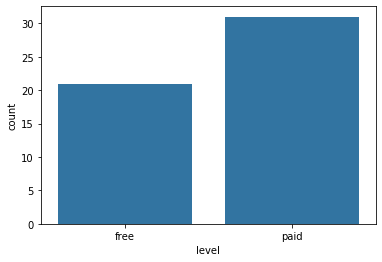

In [132]:
# Plot to see the distribution between paid and free users
level_df = df_format.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(data = level_df, x = 'level', y = 'count', color = sns.color_palette()[0])

### 3. Create churn label to identify users who churned or not

In [81]:
# Create a boolean function to check if a user canceled or not
flag_cancel_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_format = df_format.withColumn('cancel_event', flag_cancel_event('page'))

In [29]:
# df_format.show(5)

+---------+------+-------------+---------+-----+--------------------+--------+---------+------+-------------------+-------------------+-------+
|     auth|gender|itemInSession|   length|level|            location|    page|sessionId|userId|               time|   registrationTime|churned|
+---------+------+-------------+---------+-----+--------------------+--------+---------+------+-------------------+-------------------+-------+
|Logged In|     M|           50|277.89016| paid|     Bakersfield, CA|NextSong|       29|    30|2018-09-30 19:01:57|2018-09-28 17:22:42|      0|
|Logged In|     M|           79|236.09424| free|Boston-Cambridge-...|NextSong|        8|     9|2018-09-30 19:03:00|2018-09-30 13:20:30|      0|
|Logged In|     M|           51| 282.8273| paid|     Bakersfield, CA|NextSong|       29|    30|2018-09-30 19:06:34|2018-09-28 17:22:42|      0|
|Logged In|     M|           80|262.71302| free|Boston-Cambridge-...|NextSong|        8|     9|2018-09-30 19:06:56|2018-09-30 13:20:30| 

In [111]:
# create churn label
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_format = df_format.withColumn('churn_event', flag_churn_event('page'))

# label user who churned
windowval = Window.partitionBy('userId')
df_format = df_format.withColumn('churned', max('churn_event').over(windowval))

In [110]:
df_format.show(5)

+---------+------+-------------+---------+-----+--------------------+---------+---------+------+-------------------+-------------------+-----------+-----+
|     auth|gender|itemInSession|   length|level|            location|     page|sessionId|userId|               time|   registrationTime|churn_event|churn|
+---------+------+-------------+---------+-----+--------------------+---------+---------+------+-------------------+-------------------+-----------+-----+
|Logged In|     F|            0|202.97098| free|Bridgeport-Stamfo...| NextSong|       31|100010|2018-10-08 07:58:54|2018-09-26 21:45:40|          0|    0|
|Logged In|     F|            1|196.54485| free|Bridgeport-Stamfo...| NextSong|       31|100010|2018-10-08 08:02:16|2018-09-26 21:45:40|          0|    0|
|Logged In|     F|            2|263.13098| free|Bridgeport-Stamfo...| NextSong|       31|100010|2018-10-08 08:05:32|2018-09-26 21:45:40|          0|    0|
|Logged In|     F|            3|     null| free|Bridgeport-Stamfo...|T

#### Question 1: Churn happened most likely at what time of the day?

In [112]:
# format timestamp to hours and creat a new column
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour, IntegerType())
df_hour = df.withColumn('hour',get_hour(df.ts))

# format timestamp to days of a week and creat a new column
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).weekday(), IntegerType())
df_weekday = df.withColumn('weekday',get_weekday(df.ts))



# format timestamp to days and creat a new column
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).day, IntegerType())
df_day = df.withColumn('day',get_day(df.ts))


Text(0, 0.5, 'Number of churned users')

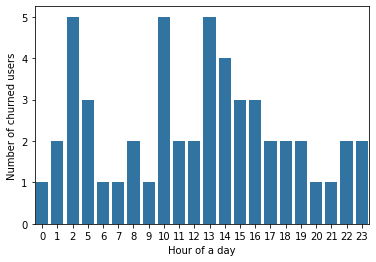

In [113]:
# Count numbers of users who churned by hours of the day and plot the result
cancel_hour = df_hour.filter(df_hour.page == 'Cancellation Confirmation').select(['userId','page','hour']).toPandas()
user_count_cancel = cancel_hour.groupby('hour').userId.count()
user_count_cancel= user_count_cancel.reset_index(name='userCount').sort_values(by='hour')
sns.barplot(data=user_count_cancel, x=user_count_cancel['hour'], y=user_count_cancel['userCount'], color=sns.color_palette()[0])
plt.xlabel('Hour of a day')
plt.ylabel('Number of churned users')

Text(0, 0.5, 'Number of churned users')

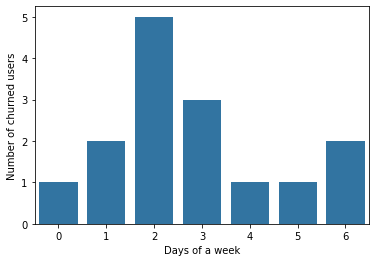

In [114]:
# Count numbers of users who churned by days of the week and plot the result
cancel_weekday = df_weekday.filter(df_weekday.page == 'Cancellation Confirmation').select(['userId','page','weekday']).toPandas()
user_count_weekday = cancel_weekday.groupby('weekday').userId.count()
user_count_weekday= user_count_weekday.reset_index(name='userCount').sort_values(by='weekday')
sns.barplot(data=user_count_weekday, x=user_count_weekday['weekday'], y=user_count_cancel['userCount'], color=sns.color_palette()[0])
plt.xlabel('Days of a week')
plt.ylabel('Number of churned users')

It shows that more people churned on Tuesday

Text(0, 0.5, 'Number of churned users')

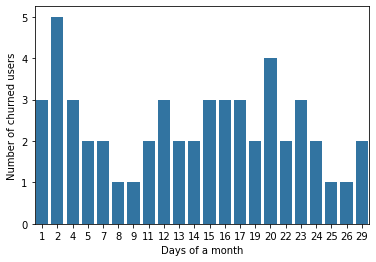

In [115]:
# Count numbers of users who churned by days of the week and plot the result
cancel_day = df_day.filter(df_day.page == 'Cancellation Confirmation').select(['userId','page','day']).toPandas()
user_count_day = cancel_day.groupby('day').userId.count()
user_count_day= user_count_day.reset_index(name='userCount').sort_values(by='day')
sns.barplot(data=user_count_day, x=user_count_day['day'], y=user_count_day['userCount'], color=sns.color_palette()[0])
plt.xlabel('Days of a month')
plt.ylabel('Number of churned users')

The above bar chart shows that people tend to Churn at 10am, 1pm and 2am. 

####  Question 2: Is there any difference in genders in terms of churn?

In [129]:
gender_churn = df_format.drop_duplicates(['userId', 'gender']).groupby(['churned', 'gender']).count().sort("churned").toPandas()
gender_churn.head()

,churned,gender,count
0,0,M,89
1,0,F,84
2,1,F,20
3,1,M,32


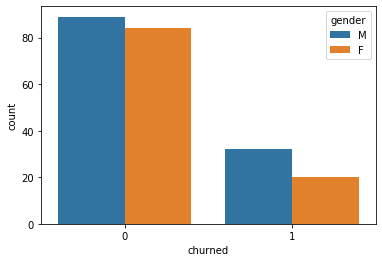

In [130]:
sns.barplot(x = 'churned', y = 'count', data = gender_churn, hue = 'gender')

We can see that there are more men users than women users in both churned and not churned category. 

#### Question 3: Is there any difference between churned and not churned users with respect to number of songs played per session?

In [157]:
# total_songs_df = df_format.where('page == "NextSong"').groupby(['churned', 'userId', 'sessionId']).count()\
#     .groupby(['churned', 'userId']).agg({'count': 'avg'})\
#     .withColumnRenamed('avg(count)', 'songsPerSession').toPandas()
# total_songs_df.head()

,churned,userId,songsPerSession
0,0,100010,39.285714
1,0,200002,64.500000
2,1,125,8.000000
3,0,124,145.678571
4,1,51,211.100000


In [164]:
def avg_songs(col):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-164-5eec01bca7d2>, line 1)

In [163]:
total_songs_df = df_format.filter(df_format.page == 'NextSong').select('churned','userId','sessionId').toPandas()
total_songs_df.head()

,churned,userId,sessionId
0,0,100010,31
1,0,100010,31
2,0,100010,31
3,0,100010,31
4,0,100010,31


In [ ]:
total_songs_df.groupby('churned').agg({'sessionId':ave})

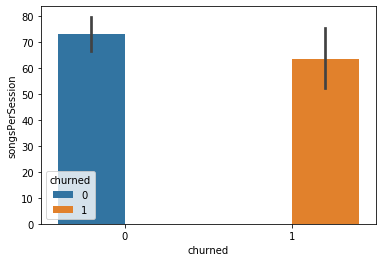

In [160]:
sns.barplot(x = 'churned', y = 'songsPerSession', data = total_songs_df, hue = 'churned')

# Feature Engineering
Since we now familiar with the data, the next stept is to build out the features I find promising to train the model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary


### Feature 1:  Total number of songs per user has listened

In [170]:
feat1 = df.select('userId','song').groupby('userId').count().withColumnRenamed('count','totalSong')
feat1.show(5)

+------+---------+
|userId|totalSong|
+------+---------+
|100010|      381|
|200002|      474|
|   125|       11|
|    51|     2464|
|   124|     4825|
+------+---------+
only showing top 5 rows



### Feature 2: User lifetime 

In [ ]:
feat2 = df.select('userId','registration','ts')\
    .withColumn('totalLifetime',(df.ts - df.registration))\
    .groupby('userId')\
    .agg({'totalLifetime':'max'}).withColumnRenamed('max(totalLifetime)','totalLifetime')\
    .select('userId', (col('totalLifetime')/1000/3600/24).alias('totalLifetime'))
                
feat2.show(5)

### Feature 3: Average number of  songs listened per session

In [225]:
feat3 = df.filter(df.page == 'NextSong') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avgSongsPerSession')
feat3.show(5)

+------+------------------+
|userId|avgSongsPerSession|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



### Feature 4: Number of thumbs up

In [186]:
feat4 = df.filter(df.page == 'Thumbs Up').select('userId').groupby('userId').count().withColumnRenamed('count','totalThumbsup')
feat4.show(5)

+------+-------------+
|userId|totalThumbsup|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
+------+-------------+
only showing top 5 rows



### Feature 5: Number of thumbs down

In [187]:
feat5 = df.filter(df.page == 'Thumbs Down').select('userId').groupby('userId').count().withColumnRenamed('count','totalThumbsdown')
feat5.show(5)

+------+---------------+
|userId|totalThumbsdown|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
+------+---------------+
only showing top 5 rows



### Feature 6:  Total number of adding friends

In [223]:
feat6 = df.filter(df.page == 'Add Friend').select('userId').groupby('userId').count().withColumnRenamed('count','totalAddFriend')
feat6.show(5)

+------+--------------+
|userId|totalAddFriend|
+------+--------------+
|100010|             4|
|200002|             4|
|    51|            28|
|   124|            74|
|     7|             1|
+------+--------------+
only showing top 5 rows



### Feature 7: Total number of adding to playlist

In [222]:
feat7 = df.filter(df.page == 'Add to Playlist').select('userId').groupby('userId').count().withColumnRenamed('count','totalAddList')
feat7.show(5)


+------+------------+
|userId|totalAddList|
+------+------------+
|100010|           7|
|200002|           8|
|    51|          52|
|   124|         118|
|     7|           5|
+------+------------+
only showing top 5 rows



### Feature 8: Total length of listening to songs per user

In [221]:
feat8 = df.select('userId','length').groupby('userId').sum().withColumnRenamed('sum(length)', 'totalListenLength')
feat8.show(5)

+------+------------------+
|userId| totalListenLength|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927900008|
+------+------------------+
only showing top 5 rows



### Feature 9: Total number of interactions per user

In [220]:
feat9 = df.groupby('userId').count().withColumnRenamed('count','totalInteraction')
feat9.show(5)

+------+----------------+
|userId|totalInteraction|
+------+----------------+
|100010|             381|
|200002|             474|
|   125|              11|
|    51|            2464|
|   124|            4825|
+------+----------------+
only showing top 5 rows



### Feature 10: Whether a user downgraded or not

In [211]:
# create downgrade flag
flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
df = df.withColumn('downgrade_event', flag_downgrade_event('page'))

# label user who downgraded
windowvald = Window.partitionBy('userId')
df = df.withColumn('downgraded', max('downgrade_event').over(windowvald))

feat10 = df.select('userId','downgraded').dropDuplicates()
feat10.show(10)

+------+----------+
|userId|downgraded|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         0|
|   124|         0|
|    51|         0|
|     7|         0|
|    15|         0|
|    54|         1|
|   155|         0|
|100014|         0|
+------+----------+
only showing top 10 rows



### Feature 11:  Whether a user paid or not 

In [230]:
# create paid flag
flag_paid_event = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df = df.withColumn('paid_event', flag_paid_event('level'))

# label user who paid
windowvalp = Window.partitionBy('userId')
df = df.withColumn('paid', max('paid_event').over(windowvalp))

feat11 = df.select('userId','paid').dropDuplicates()
feat11.show(5)

+------+----+
|userId|paid|
+------+----+
|100010|   0|
|200002|   1|
|   125|   0|
|   124|   1|
|    51|   1|
+------+----+
only showing top 5 rows



### Label for prediction

In [240]:
label = df_format.select('userId',df_format.churned.alias('label')).dropDuplicates()
label.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



### Wrap up all the features together

In [241]:
model_df = feat1.join(feat2,'userId','inner') \
    .join(feat3,'userId','inner') \
    .join(feat4,'userId','inner') \
    .join(feat5,'userId','inner') \
    .join(feat6,'userId','inner') \
    .join(feat7,'userId','inner') \
    .join(feat8,'userId','inner') \
    .join(feat9,'userId','inner') \
    .join(feat10,'userId','inner') \
    .join(feat11,'userId','inner') \
    .join(label,'userId','inner') \
    .drop('userId')
model_df.show(5)

+---------+------------------+------------------+-------------+---------------+--------------+------------+------------------+----------------+----------+----+-----+
|totalSong|     totalLifetime|avgSongsPerSession|totalThumbsup|totalThumbsdown|totalAddFriend|totalAddList| totalListenLength|totalInteraction|downgraded|paid|label|
+---------+------------------+------------------+-------------+---------------+--------------+------------+------------------+----------------+----------+----+-----+
|      381|  55.6436574074074|39.285714285714285|           17|              5|             4|           7|       66940.89735|             381|         0|   0|    0|
|      474| 70.07462962962963|              64.5|           21|              6|             4|           8| 94008.87593999993|             474|         0|   1|    0|
|     4825|131.55591435185184|145.67857142857142|          171|             41|            74|         118|1012312.0927900008|            4825|         0|   1|    0|
|   

In [242]:
model_df.write.mode('overwrite').save('model_df.json')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [291]:
# load data
data = spark.read.load('model_df.json')
data.show(5)

+---------+------------------+------------------+-------------+---------------+--------------+------------+------------------+----------------+----------+----+-----+
|totalSong|     totalLifetime|avgSongsPerSession|totalThumbsup|totalThumbsdown|totalAddFriend|totalAddList| totalListenLength|totalInteraction|downgraded|paid|label|
+---------+------------------+------------------+-------------+---------------+--------------+------------+------------------+----------------+----------+----+-----+
|     3102| 62.09569444444444| 88.86206896551724|          135|             21|            33|          72| 648839.6085999997|            3102|         0|   1|    0|
|     1863|120.89991898148149|              92.0|           72|             20|            26|          51|389584.29664000025|            1863|         1|   1|    0|
|     6880| 80.60512731481482| 84.53731343283582|          277|             75|           143|         148|1410075.4463300004|            6880|         1|   1|    0|
|   

## Vectorize features

our dataset has 11 features including 9 numerical features and 2 binary features. We will first vectorize each feature and then build a pipeline 

In [292]:
numerical_cols = ['totalSong','totalLifetime','avgSongsPerSession','totalThumbsup','totalThumbsdown',
                  'totalAddFriend','totalAddList','totalListenLength','totalInteraction']
binary_cols = ['downgraded','paid']


# Vectorize and standarize numerical features
num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='num_vect')
scaler = StandardScaler(inputCol='num_vect', outputCol='num_scaled', withStd= True, withMean=True)

# Add binary features
assembler = VectorAssembler(inputCols = binary_cols + ["num_scaled"], outputCol = "features")

In [293]:
def evaluate(model):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-293-6a578318d242>, line 2)

## Train/test split

In [294]:
train,val = data.randomSplit([0.8,0.2], seed=42)
train.show()

+---------+------------------+------------------+-------------+---------------+--------------+------------+------------------+----------------+----------+----+-----+
|totalSong|     totalLifetime|avgSongsPerSession|totalThumbsup|totalThumbsdown|totalAddFriend|totalAddList| totalListenLength|totalInteraction|downgraded|paid|label|
+---------+------------------+------------------+-------------+---------------+--------------+------------+------------------+----------------+----------+----+-----+
|      117|124.55060185185185|              85.0|            6|              1|             3|           3|       19961.03902|             117|         0|   0|    0|
|      292| 87.46262731481481| 23.88888888888889|            9|              3|             7|           7|53062.746589999995|             292|         0|   0|    0|
|      310| 85.08340277777778|42.833333333333336|           17|              3|             6|           7|       67703.47208|             310|         0|   1|    1|
|   

## Logistic Regression

In [295]:
lr = LogisticRegression()
pipeline_lr = Pipeline(stages=[num_assembler, scaler, assembler, lr])

### Grid search CV

In [296]:
# Parameter combinations
param_grid_lr = ParamGridBuilder()\
.addGrid(lr.maxIter, [10, 30]) \
.addGrid(lr.regParam, [0.0, 0.1]) \
.addGrid(lr.elasticNetParam, [0.0, 0.5]) \
.build()

# Grid search with cross validation
crossval_lr = CrossValidator(estimator = pipeline_lr,
                          estimatorParamMaps = param_grid_lr,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

In [298]:
# train model
start = time.time()
crossval_model_lr = crossval_lr.fit(train)
end = time.time()
print('Time spent: {} seconds'.format(round(end-start)))


Time spent: 29 seconds


In [299]:
scores = crossval_model_lr.avgMetrics
scores

[0.7416741087981356,
 0.7416741087981356,
 0.7376476243445098,
 0.7532860585836114,
 0.7415406668785423,
 0.7415406668785423,
 0.7376476243445098,
 0.7532860585836114]

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.